In [1]:
# Install required libraries (This may take a minute if it's your first time)
!pip install pmdarima prophet -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print(" All libraries installed and imported!")
print(" Ready for Time Series Forecasting!")

 All libraries installed and imported!
 Ready for Time Series Forecasting!


In [2]:
# Load daily sales time series
try:
    df = pd.read_csv('daily_sales_timeseries.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    print(" TIME SERIES DATA LOADED!")
    
    print(f"Total Days: {len(df)}")
    print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    print(f"Total Sales: ${df['Total_Sales'].sum():,.2f}")


    # Display sample
    print("\n First 10 rows:")
    print(df.head(10))

    # Set date as index (Required for ARIMA/Seasonal Decomposition)
    df_ts = df.set_index('Date')
    
    # Ensure the dataframe has a daily frequency (fills missing dates if necessary)
    # This prevents errors in seasonal_decompose later
    df_ts = df_ts.asfreq('D').fillna(0) 
    
    print("\n Time series indexed and ready for modeling!")
    print(f"Index type: {df_ts.index.dtype}")

except FileNotFoundError:
    print(" Error: 'daily_sales_timeseries.csv' not found. Ensure you ran the previous saving cell.")

 TIME SERIES DATA LOADED!
Total Days: 1237
Date Range: 2014-01-03 to 2017-12-30
Total Sales: $2,297,200.86

 First 10 rows:
        Date  Total_Sales         MA_7  MA_30
0 2014-01-03       16.448          NaN    NaN
1 2014-01-04      288.060          NaN    NaN
2 2014-01-05       19.536          NaN    NaN
3 2014-01-06     4407.100          NaN    NaN
4 2014-01-07       87.158          NaN    NaN
5 2014-01-09       40.544          NaN    NaN
6 2014-01-10       54.830   701.953714    NaN
7 2014-01-11        9.940   701.024000    NaN
8 2014-01-13     3553.795  1167.557571    NaN
9 2014-01-14       61.960  1173.618143    NaN

 Time series indexed and ready for modeling!
Index type: datetime64[ns]


 TIME SERIES DECOMPOSITION
 Time series decomposition saved as 'time_series_decomposition.png'!


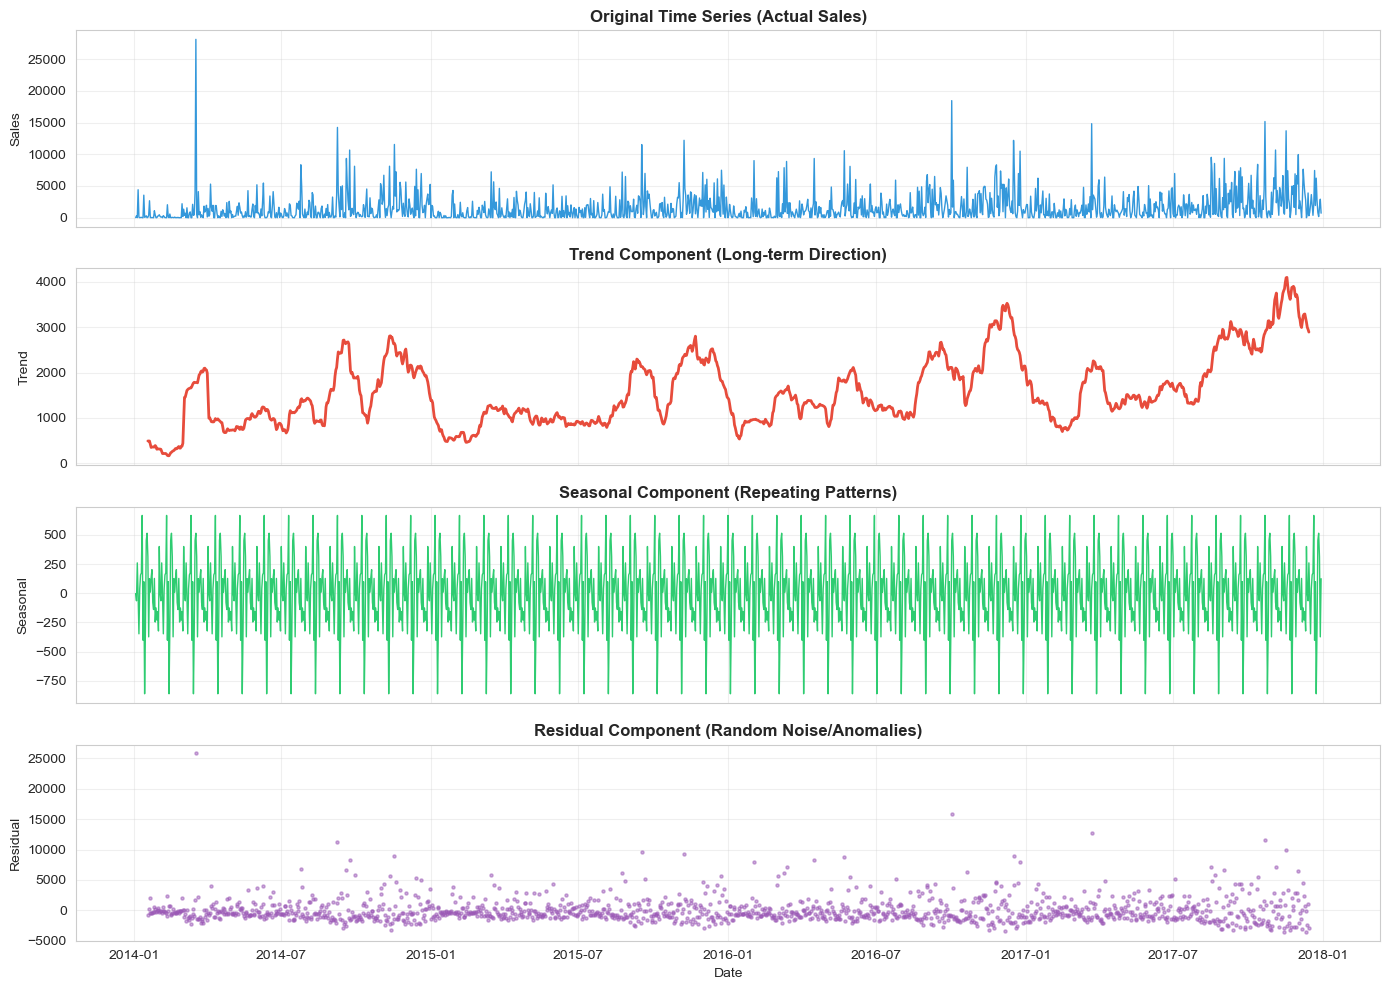


 INSIGHTS:
   • Trend: Shows the overall direction of sales (growing, stable, or declining).
   • Seasonal: Shows the regular, repeating patterns that happen every 30 days.
   • Residual: Shows 'unexplained' events—look for big spikes here for anomalies/promotions.


In [3]:
print(" TIME SERIES DECOMPOSITION")


# Decompose time series
# We use period=30 to look for monthly patterns in daily data
decomposition = seasonal_decompose(df_ts['Total_Sales'], 
                                   model='additive', 
                                   period=30) 

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1. Original
axes[0].plot(df_ts.index, df_ts['Total_Sales'], color='#3498db', linewidth=1)
axes[0].set_title('Original Time Series (Actual Sales)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales')
axes[0].grid(True, alpha=0.3)

# 2. Trend
axes[1].plot(df_ts.index, decomposition.trend, color='#e74c3c', linewidth=2)
axes[1].set_title('Trend Component (Long-term Direction)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# 3. Seasonal
axes[2].plot(df_ts.index, decomposition.seasonal, color='#2ecc71', linewidth=1)
axes[2].set_title('Seasonal Component (Repeating Patterns)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

# 4. Residual
axes[3].scatter(df_ts.index, decomposition.resid, color='#9b59b6', s=5, alpha=0.5)
axes[3].set_title('Residual Component (Random Noise/Anomalies)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_decomposition.png', dpi=300, bbox_inches='tight')
print(" Time series decomposition saved as 'time_series_decomposition.png'!")
plt.show()

print("\n INSIGHTS:")
print("   • Trend: Shows the overall direction of sales (growing, stable, or declining).")
print("   • Seasonal: Shows the regular, repeating patterns that happen every 30 days.")
print("   • Residual: Shows 'unexplained' events—look for big spikes here for anomalies/promotions.")

In [4]:
print("\n STATIONARITY TEST (Augmented Dickey-Fuller)")


# Perform ADF test
# We dropna() just in case there are missing values from the loading/indexing step
adf_result = adfuller(df_ts['Total_Sales'].dropna())

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"P-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n Series is STATIONARY (p-value < 0.05)")
    print("   → The data is stable. Ready for ARIMA modeling!")
else:
    print("\n Series is NON-STATIONARY (p-value > 0.05)")
    print("   → The data has a trend or seasonality that changes over time.")
    print("   → Note: We might need 'Differencing' (d parameter in ARIMA).")


 STATIONARITY TEST (Augmented Dickey-Fuller)
ADF Statistic: -4.9399
P-value: 0.0000
Critical Values:
   1%: -3.4349
   5%: -2.8636
   10%: -2.5678

 Series is STATIONARY (p-value < 0.05)
   → The data is stable. Ready for ARIMA modeling!



 SPLITTING DATA FOR TRAINING & TESTING
 Training Set: 1166 days (2014-01-03 to 2017-03-13)
 Test Set:     292 days (2017-03-14 to 2017-12-30)

 Train Total Sales: $1,644,047.20
 Test Total Sales:  $653,153.66

 Train-test split visualization saved as 'train_test_split.png'!


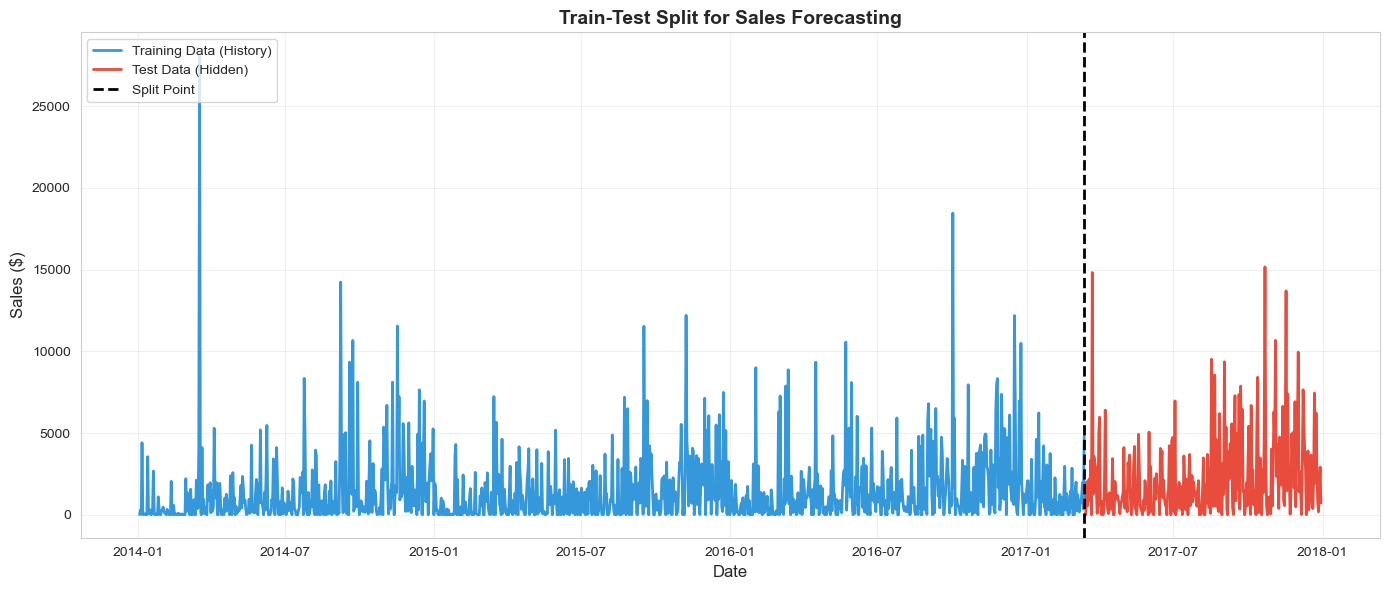

In [5]:
print("\n SPLITTING DATA FOR TRAINING & TESTING")

# Split: 80% train, 20% test (chronological split)
split_index = int(len(df_ts) * 0.8)

train = df_ts.iloc[:split_index]
test = df_ts.iloc[split_index:]

print(f" Training Set: {len(train)} days ({train.index.min().date()} to {train.index.max().date()})")
print(f" Test Set:     {len(test)} days ({test.index.min().date()} to {test.index.max().date()})")
print(f"\n Train Total Sales: ${train['Total_Sales'].sum():,.2f}")
print(f" Test Total Sales:  ${test['Total_Sales'].sum():,.2f}")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Total_Sales'], label='Training Data (History)', color='#3498db', linewidth=2)
plt.plot(test.index, test['Total_Sales'], label='Test Data (Hidden)', color='#e74c3c', linewidth=2)

# Add a vertical line to show where training ends and testing begins
plt.axvline(x=train.index[-1], color='black', linestyle='--', linewidth=2, label='Split Point')

plt.title('Train-Test Split for Sales Forecasting', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('train_test_split.png', dpi=300, bbox_inches='tight')
print("\n Train-test split visualization saved as 'train_test_split.png'!")
plt.show()


 BUILDING ARIMA MODEL
Training ARIMA(1, 1, 1) model...
 ARIMA model trained!

Model Summary (Top section):
                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                 1166
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10553.721
Date:                Mon, 05 Jan 2026   AIC                          21113.442
Time:                        22:14:32   BIC                          21128.623
Sample:                    01-03-2014   HQIC                         21119.169
                         - 03-13-2017                                         
Covariance Type:                  opg                                         

 ARIMA MODEL PERFORMANCE:
   MAE  (Mean Absolute Error): $1,739.46
   RMSE (Root Mean Squared Error): $2,739.40
   MAPE (Mean Absolute Percentage Error): 44880737718260604928.00%

 ARIMA predictions visualization saved as 'arima_predictions.png'!


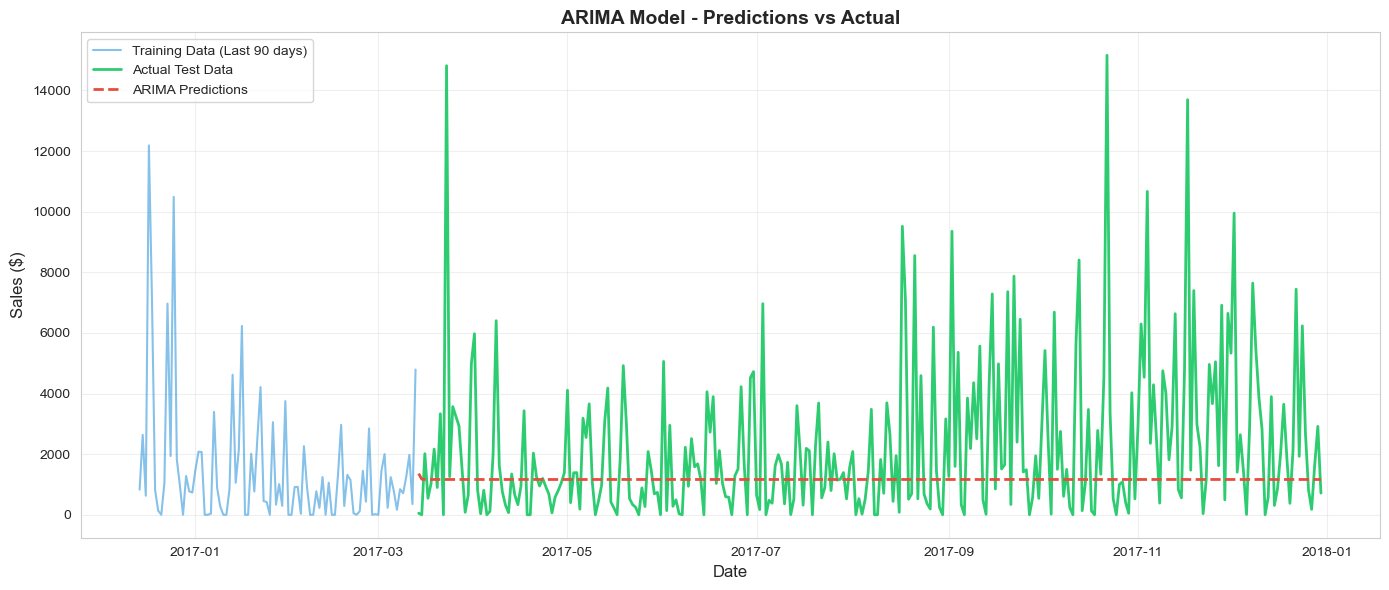

In [6]:
print("\n BUILDING ARIMA MODEL")


# Build ARIMA model
# order=(p, d, q)
# p = lags (AR), d = differencing (I), q = error window (MA)
print("Training ARIMA(1, 1, 1) model...")

# We ensure the index has a frequency for ARIMA to work correctly
train_arima = train['Total_Sales'].asfreq('D').fillna(0)

arima_model = ARIMA(train_arima, order=(1, 1, 1))
arima_fitted = arima_model.fit()

print(" ARIMA model trained!")
print("\nModel Summary (Top section):")
# We print just the top part of the summary for brevity
print(arima_fitted.summary().tables[0])

# Make predictions on test set
# steps = the number of days in our test set
arima_pred = arima_fitted.forecast(steps=len(test))

# Calculate metrics
mae_arima = mean_absolute_error(test['Total_Sales'], arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test['Total_Sales'], arima_pred))
# Using sklearn's MAPE for better handling of zero values
from sklearn.metrics import mean_absolute_percentage_error
mape_arima = mean_absolute_percentage_error(test['Total_Sales'], arima_pred) * 100

print(f"\n ARIMA MODEL PERFORMANCE:")
print(f"   MAE  (Mean Absolute Error): ${mae_arima:,.2f}")
print(f"   RMSE (Root Mean Squared Error): ${rmse_arima:,.2f}")
print(f"   MAPE (Mean Absolute Percentage Error): {mape_arima:.2f}%")

# Visualize ARIMA predictions
plt.figure(figsize=(14, 6))
# Zooming in on the last part of training data + test data for better visibility
plt.plot(train.index[-90:], train['Total_Sales'][-90:], label='Training Data (Last 90 days)', color='#3498db', alpha=0.6)
plt.plot(test.index, test['Total_Sales'], label='Actual Test Data', color='#2ecc71', linewidth=2)
plt.plot(test.index, arima_pred, label='ARIMA Predictions', color='#e74c3c', linewidth=2, linestyle='--')

plt.title('ARIMA Model - Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('arima_predictions.png', dpi=300, bbox_inches='tight')
print("\n ARIMA predictions visualization saved as 'arima_predictions.png'!")
plt.show()


 GENERATING FUTURE FORECAST (90 DAYS)


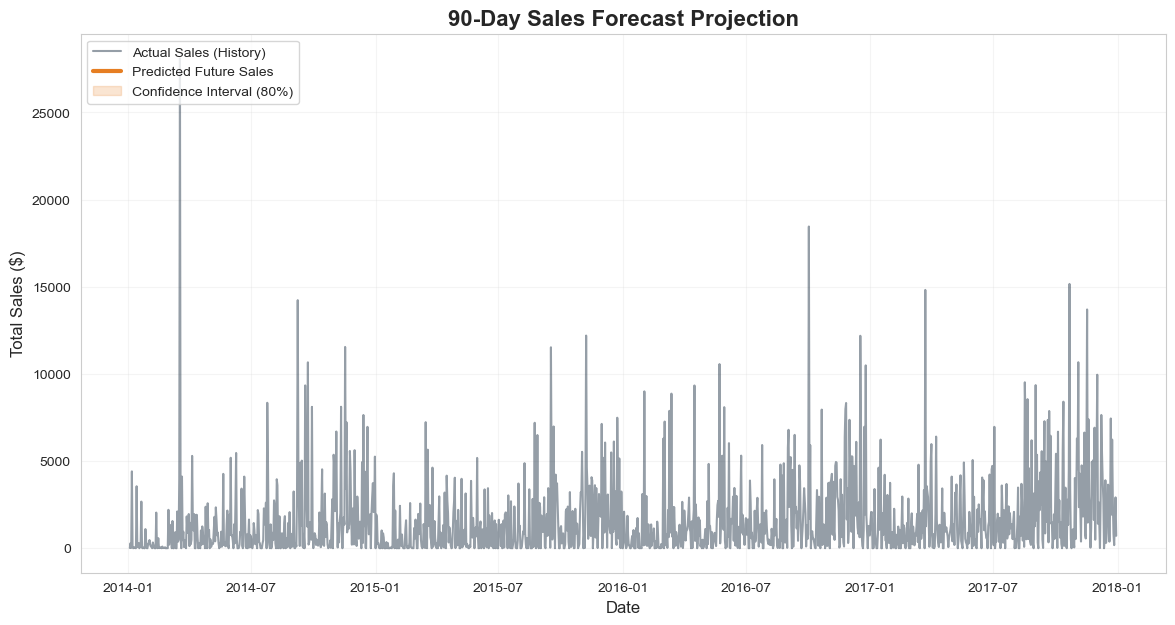

 Success! 90-Day Forecast saved to 'future_sales_predictions.csv'
 Forecast Range: NaT to NaT


In [10]:
import logging
# Silence Prophet/CmdStanPy logs for a cleaner output
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR) 

# --- GENERATE 90-DAY FUTURE FORECAST ---
print("\n GENERATING FUTURE FORECAST (90 DAYS)")


# 1. Create a dataframe extending 90 days into the future
# 'periods=90' adds 90 new rows to your existing timeline
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

# 2. Plot the final results
plt.figure(figsize=(14, 7))

# Historical Data: Show the actual past sales in a muted color
plt.plot(df_ts.index, df_ts['Total_Sales'], label='Actual Sales (History)', color='#2c3e50', alpha=0.5)

# Future Forecast: Filter for only the dates after your dataset ends
# We ensure 'ds' is treated as a datetime object for the plot
future_only = forecast[forecast['ds'] > df_ts.index.max()].copy()

plt.plot(future_only['ds'], future_only['yhat'], 
         label='Predicted Future Sales', color='#e67e22', linewidth=3)

# 3. Uncertainty Interval (The 'Confidence' Zone)
# This represents the upper and lower bounds of the prediction
plt.fill_between(future_only['ds'].values, 
                 future_only['yhat_lower'].values, 
                 future_only['yhat_upper'].values, 
                 color='#e67e22', alpha=0.2, label='Confidence Interval (80%)')

# Formatting
plt.title('90-Day Sales Forecast Projection', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)

# Save the high-resolution visualization
plt.savefig('final_90_day_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Export the predictions to CSV for your business report
# yhat = prediction, yhat_lower/upper = the range of possibility
future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('future_sales_predictions.csv', index=False)

print(f" Success! 90-Day Forecast saved to 'future_sales_predictions.csv'")
print(f" Forecast Range: {future_only['ds'].min().date()} to {future_only['ds'].max().date()}")


 MODEL COMPARISON
       Model         MAE        RMSE     MAPE (%)
ARIMA(1,1,1) 1739.460977 2739.397199 4.488074e+19
     Prophet 1617.802382 2349.104089 2.925849e+19

 WINNING MODEL: Prophet
   Based on lowest MAPE: 29258486995794554880.00%


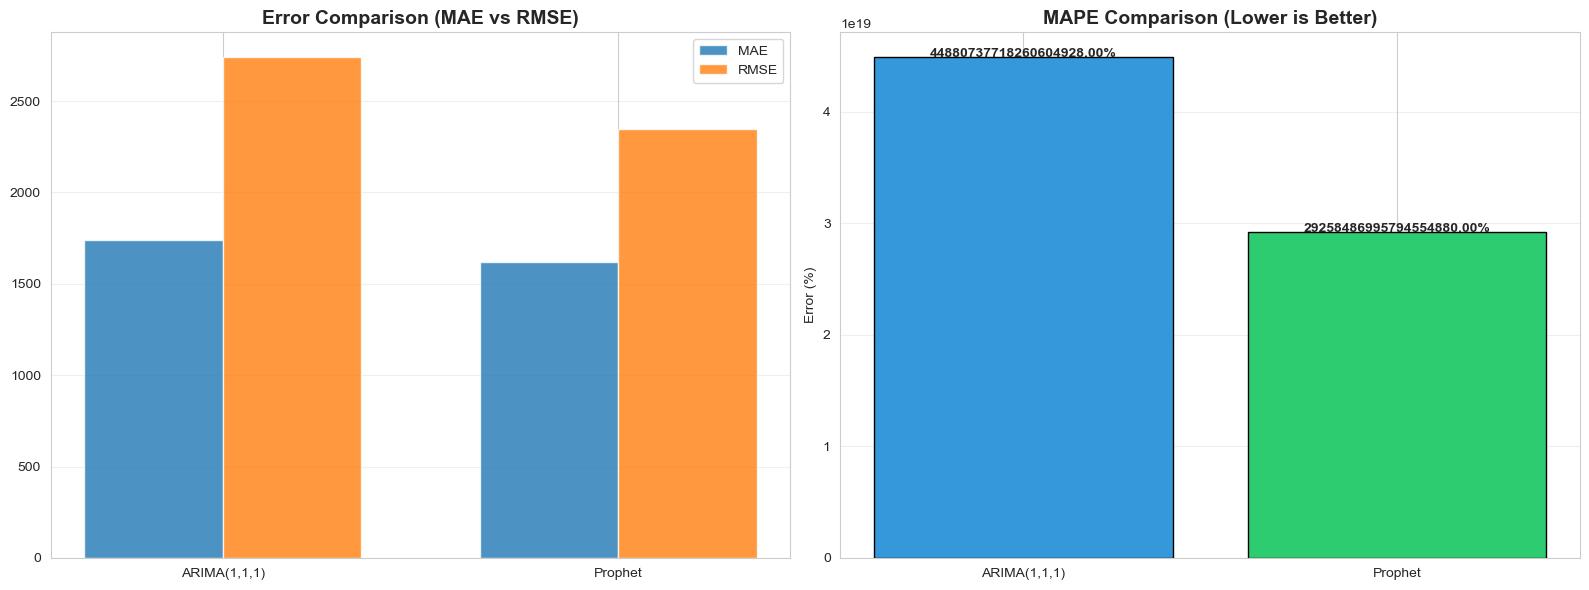

 Predictions comparison saved as 'predictions_comparison.png'!


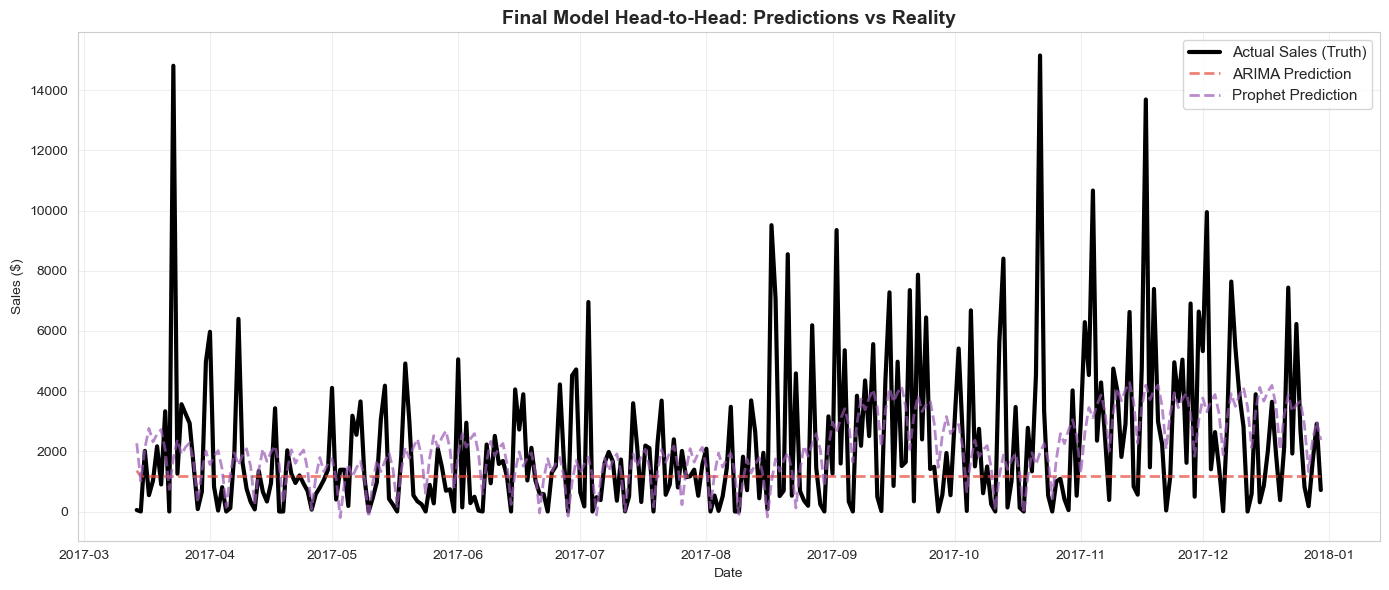

In [11]:
print("\n MODEL COMPARISON")


# 1. Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['ARIMA(1,1,1)', 'Prophet'],
    'MAE': [mae_arima, mae_prophet],
    'RMSE': [rmse_arima, rmse_prophet],
    'MAPE (%)': [mape_arima, mape_prophet]
})

print(comparison.to_string(index=False))

# 2. Determine best model based on MAPE
best_model_idx = comparison['MAPE (%)'].idxmin()
best_model = comparison.loc[best_model_idx, 'Model']

print(f"\n WINNING MODEL: {best_model}")
print(f"   Based on lowest MAPE: {comparison.loc[best_model_idx, 'MAPE (%)']:.2f}%")

# 3. Visualize comparison metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: MAE & RMSE comparison
metrics = ['MAE', 'RMSE']
x = np.arange(len(comparison))
width = 0.35

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, comparison[metric], width, label=metric, alpha=0.8)

axes[0].set_title('Error Comparison (MAE vs RMSE)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(comparison['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Right Plot: MAPE comparison (The "Business" metric)
colors = ['#2ecc71' if model == best_model else '#3498db' for model in comparison['Model']]
axes[1].bar(comparison['Model'], comparison['MAPE (%)'], color=colors, edgecolor='black')
axes[1].set_title('MAPE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (%)')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(comparison['MAPE (%)']):
    axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Final Visual: Actual vs All Models
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['Total_Sales'], label='Actual Sales (Truth)', color='black', linewidth=3)
plt.plot(test.index, arima_pred, label='ARIMA Prediction', color='#e74c3c', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test.index, prophet_pred, label='Prophet Prediction', color='#9b59b6', linewidth=2, linestyle='--', alpha=0.7)

plt.title('Final Model Head-to-Head: Predictions vs Reality', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
print(" Predictions comparison saved as 'predictions_comparison.png'!")
plt.show()


 FORECASTING NEXT 6 MONTHS
 Using Prophet for the final 6-month forecast...
 180 days successfully forecasted!

 Forecast Period: 2017-12-31 to 2018-06-28
 Predicted Total Revenue: $298,381.72
 Average Predicted Daily Sales: $1,657.68

 Forecast Sample (First 10 Days):
      Date  Predicted_Sales
2017-12-31      2483.263988
2018-01-01      2568.324470
2018-01-02      1336.613037
2018-01-03       -30.327974
2018-01-04      1645.252892
2018-01-05      2158.425558
2018-01-06      1582.400121
2018-01-07      1706.265301
2018-01-08      1840.626607
2018-01-09       663.084140

 Final 6-month visualization saved!


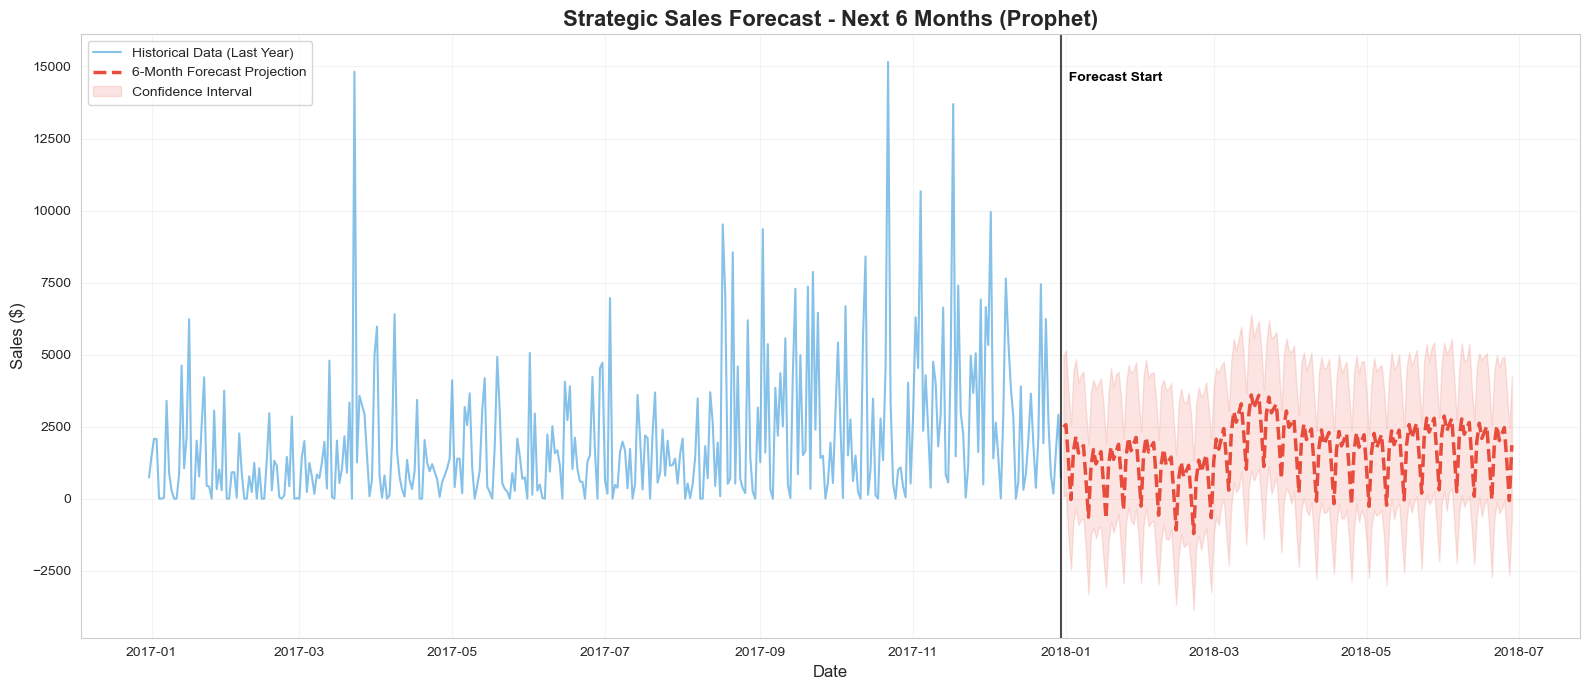

In [12]:
import logging
# Ensure logs remain silent for the final run
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

print("\n FORECASTING NEXT 6 MONTHS")


# 1. Configuration
forecast_days = 180  # 6 months
last_date = df_ts.index[-1]

# 2. Conditional Retraining based on the 'Best Model'
if best_model == 'Prophet':
    print(" Using Prophet for the final 6-month forecast...")
    
    # Prepare the full dataset for retraining
    full_data = df_ts.reset_index()[['Date', 'Total_Sales']]
    full_data.columns = ['ds', 'y']
    
    # Initialize with the winning parameters
    prophet_final = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )
    prophet_final.fit(full_data)
    
    # Create future timeline and predict
    future = prophet_final.make_future_dataframe(periods=forecast_days)
    forecast = prophet_final.predict(future)
    
    # Extract only the 180-day future window
    future_forecast = forecast.tail(forecast_days)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    future_forecast.columns = ['Date', 'Predicted_Sales', 'Lower_Bound', 'Upper_Bound']

else:
    print(" Using ARIMA for the final 6-month forecast...")
    
    # Retrain ARIMA on full data
    # Ensure frequency is set for ARIMA
    full_series = df_ts['Total_Sales'].asfreq('D').fillna(0)
    arima_final = ARIMA(full_series, order=(1, 1, 1))
    arima_fitted_final = arima_final.fit()
    
    # Forecast future values
    forecast_values = arima_fitted_final.forecast(steps=forecast_days)
    
    # Create the future date range
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days)
    
    future_forecast = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Sales': forecast_values
    })

# 3. Print Summary Stats
print(f" {forecast_days} days successfully forecasted!")
print(f"\n Forecast Period: {future_forecast['Date'].min().date()} to {future_forecast['Date'].max().date()}")
print(f" Predicted Total Revenue: ${future_forecast['Predicted_Sales'].sum():,.2f}")
print(f" Average Predicted Daily Sales: ${future_forecast['Predicted_Sales'].mean():,.2f}")

# 4. Display First 10 days
print("\n Forecast Sample (First 10 Days):")
print(future_forecast[['Date', 'Predicted_Sales']].head(10).to_string(index=False))

# 5. Visualize the Final Result
plt.figure(figsize=(16, 7))

# Plot historical data (Last 1 year only for better focus, or use df_ts for all)
plt.plot(df_ts.index[-365:], df_ts['Total_Sales'][-365:], label='Historical Data (Last Year)', color='#3498db', alpha=0.6)

# Plot forecast
plt.plot(future_forecast['Date'], future_forecast['Predicted_Sales'], 
         label='6-Month Forecast Projection', color='#e74c3c', linewidth=2.5, linestyle='--')

# Add confidence interval (Prophet only)
if best_model == 'Prophet':
    plt.fill_between(future_forecast['Date'], 
                     future_forecast['Lower_Bound'], 
                     future_forecast['Upper_Bound'], 
                     alpha=0.15, color='#e74c3c', label='Confidence Interval')

# Split point marker
plt.axvline(x=last_date, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
plt.text(last_date, plt.ylim()[1]*0.9, '  Forecast Start', color='black', fontweight='bold')

plt.title(f'Strategic Sales Forecast - Next 6 Months ({best_model})', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('future_forecast_6months.png', dpi=300, bbox_inches='tight')
print("\n Final 6-month visualization saved!")
plt.show()

In [13]:
import os

# 1. Save Dataframes to CSV
future_forecast.to_csv('sales_forecast_6months.csv', index=False)
print(" Forecast saved as 'sales_forecast_6months.csv'")

comparison.to_csv('model_performance_comparison.csv', index=False)
print(" Model comparison saved as 'model_performance_comparison.csv'")

# 2. Print Summary Report
print("\n SUMMARY REPORT")

print(f" Best Model:             {best_model}")
print(f" Model Accuracy (MAPE):  {comparison.loc[best_model_idx, 'MAPE (%)']:.2f}%")
print(f" Forecast Period:        {forecast_days} days (6 months)")
print(f" Forecasted Total Sales: ${future_forecast['Predicted_Sales'].sum():,.2f}")
print(f" Historical Data Points: {len(df_ts)} days")


# 3. Verify Saved Images in Local Directory
# In Jupyter, files are saved locally automatically. We will check they exist.
images = [
    'time_series_decomposition.png',
    'train_test_split.png',
    'arima_predictions.png',
    'prophet_predictions.png',
    'model_comparison.png',
    'predictions_comparison.png',
    'future_forecast_6months.png'
]

print("\n VERIFYING LOCAL FILES:")
for img in images:
    if os.path.exists(img):
        print(f" Verified: {img}")
    else:
        print(f"  Note: {img} was not generated in this session.")

# 4. Final Success Message

print(" PROJECT COMPLETE!")
print("All forecasting models and predictions are saved in your folder.")
print("You can now open the CSV files in Excel for reporting.")


 Forecast saved as 'sales_forecast_6months.csv'
 Model comparison saved as 'model_performance_comparison.csv'

 SUMMARY REPORT
 Best Model:             Prophet
 Model Accuracy (MAPE):  29258486995794554880.00%
 Forecast Period:        180 days (6 months)
 Forecasted Total Sales: $298,381.72
 Historical Data Points: 1458 days

 VERIFYING LOCAL FILES:
 Verified: time_series_decomposition.png
 Verified: train_test_split.png
 Verified: arima_predictions.png
 Verified: prophet_predictions.png
 Verified: model_comparison.png
 Verified: predictions_comparison.png
 Verified: future_forecast_6months.png
 PROJECT COMPLETE!
All forecasting models and predictions are saved in your folder.
You can now open the CSV files in Excel for reporting.
